### For Google Colab to import Google Drive

In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

In [2]:
# %pip install opencv-python

## Convert JPG to JPEG

In [3]:
import cv2
import os
from pathlib import Path
DATA_DIR = "dataset/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

## For Google Colab
# DATA_DIR = "drive/MyDrive/dataset/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

def jpg_to_jpeg(data_dir):
    for dir_name in os.listdir(data_dir):
        files = os.path.join(data_dir,dir_name)
        for filepaths in os.listdir(files):
            file_names = os.path.join(files,filepaths)
            if file_names.endswith(".jpg") or file_names.endswith(".JPG"):
                img = cv2.imread(str(file_names))
                cv2.imwrite(file_names[0:-4]+".jpeg", img)
                os.remove(file_names)

In [4]:
import imghdr

IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

# Import Tensorflow and Keras

In [5]:
import tensorflow as tf
import keras 

BATCH_SIZE = 64
HEIGHT = 256
WIDTH = 256
IMAGE_SIZE = (HEIGHT, WIDTH)

## StableDiffusion Dataset

In [6]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2,
    subset="training",
)

val_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2, # use 20% as validation
    subset="validation",
)
# The target labels
class_names = train_dataset.class_names
print(class_names)

Found 912 files belonging to 2 classes.
Using 730 files for training.
Found 912 files belonging to 2 classes.
Using 182 files for validation.
['AI Art', 'Real']


2024-05-16 14:12:45.802484: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-16 14:12:45.802512: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-16 14:12:45.802519: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-16 14:12:45.802535: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-16 14:12:45.802554: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
import numpy as np
from sklearn.utils import shuffle

# Shuffle the training dataset
train_dataset = train_dataset.shuffle(len(train_dataset), seed=1337)

# Separate images and labels
images = []
labels = []
for image_batch, label_batch in train_dataset:
    images.extend(image_batch)
    labels.extend(label_batch)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Find the class with fewer samples
unique_labels, class_counts = np.unique(labels, return_counts=True)
minority_class = unique_labels[np.argmin(class_counts)]

# Find the indices of the minority class
minority_indices = np.where(labels == minority_class)[0]

# Randomly sample from the majority class
majority_indices = np.where(labels != minority_class)[0]
num_samples_to_keep = len(minority_indices)
majority_indices_sampled = np.random.choice(majority_indices, size=num_samples_to_keep, replace=False)

# Combine indices of both classes
balanced_indices = np.concatenate([minority_indices, majority_indices_sampled])

# Shuffle the combined indices
balanced_indices = shuffle(balanced_indices, random_state=1337)

# Use the balanced indices to create the balanced dataset
balanced_images = images[balanced_indices]
balanced_labels = labels[balanced_indices]

# Create TensorFlow Dataset from balanced data
balanced_train_dataset = tf.data.Dataset.from_tensor_slices((balanced_images, balanced_labels))
balanced_train_dataset = balanced_train_dataset.shuffle(len(balanced_images)).batch(BATCH_SIZE)

# Print class distribution in the balanced dataset
unique_labels, class_counts = np.unique(balanced_labels, return_counts=True)
print("Class distribution in the balanced dataset:")
for label, count in zip(unique_labels, class_counts):
    print(f"Class {label}: {count} samples")

2024-05-16 14:13:16.184819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class distribution in the balanced dataset:
Class 0.0: 320 samples
Class 1.0: 320 samples


# Display sample images

/var/folders/mp/c7pgmq8j0472f05vnx5h16000000gn/T/ipykernel_42359/956514416.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(labels[i].numpy())])
2024-05-16 14:13:21.372384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


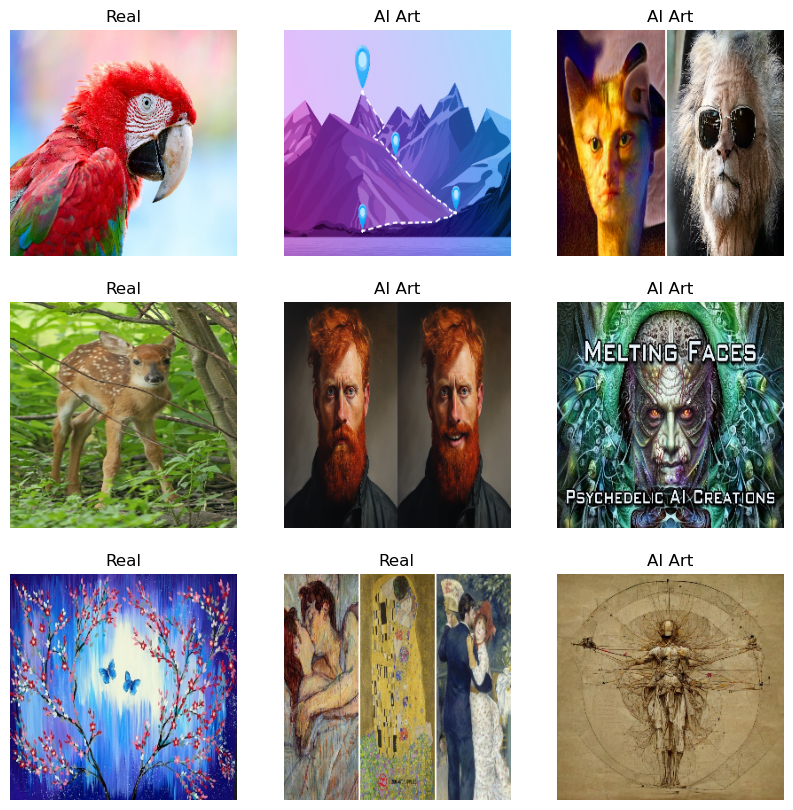

In [8]:
import matplotlib.pyplot as plt

def display_binary_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i].numpy())])
            plt.axis("off")

display_binary_images(train_dataset, class_names)

## Model

In [9]:
import tensorflow as tf

# Load the ResNet50 model pre-trained on ImageNet data
base_model = tf.keras.applications.ResNet50(input_shape=(HEIGHT, WIDTH, 3), include_top=False, weights='imagenet')

# Freeze the layers in the base model
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Combine the base model with the custom classification head
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 52s 1us/step


In [10]:
NUM_EPOCHS = 10  # Number of epochs for training

In [11]:
# Define Learning Rate Scheduling callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.2,           # Factor by which the learning rate will be reduced
    patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1             # Print message when learning rate is reduced
)

# Define Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Print message when training is stopped
    restore_best_weights=True  # Restore model weights to the point of best validation loss
)

In [12]:
# Train the model
history = model.fit(balanced_train_dataset,
                    epochs=NUM_EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[lr_scheduler, early_stopping]
                    )


Epoch 1/10


2024-05-16 14:14:17.447039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5427 - loss: 1.0337 - val_accuracy: 0.7582 - val_loss: 0.4921 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7495 - loss: 0.5295 - val_accuracy: 0.7967 - val_loss: 0.4627 - learning_rate: 0.0010
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8218 - loss: 0.4050 - val_accuracy: 0.8077 - val_loss: 0.4392 - learning_rate: 0.0010
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8879 - loss: 0.3185 - val_accuracy: 0.8242 - val_loss: 0.4472 - learning_rate: 0.0010
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8994 - loss: 0.2451 - val_accuracy: 0.8187 - val_loss: 0.4352 - learning_rate: 0.0010
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 960ms/step - accuracy: 0.9364 - loss: 0.1964 - val_accuracy: 0.8132 - val_loss: 0.4435 - learning_rate: 0.0010
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9619 - loss: 0.1580 - val_accuracy: 0.8297 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
This image is predicted to be: AI Art (100.00%)


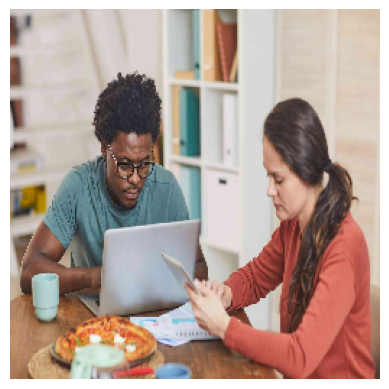

In [13]:
img_path = "dataset/AI Art vs Real Art/Real/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpeg"

img = keras.preprocessing.image.load_img(img_path, 
                                            target_size=(HEIGHT, WIDTH))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]
total_percentage = sum(predictions)
scaled_predictions = [p * 100 / total_percentage for p in predictions]

# Define class names
class_names = ["AI Art", "Real"]

# Find the predicted class with the highest probability
predicted_class_index = tf.argmax(scaled_predictions).numpy()
predicted_class_name = class_names[predicted_class_index]

# Print the predicted label
print(f"This image is predicted to be: {predicted_class_name} ({scaled_predictions[predicted_class_index]:.2f}%)")

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

dataset/AI Art vs Real Art/Real/RealArt
images32.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
This image is predicted to be: AI Art (100.00%)


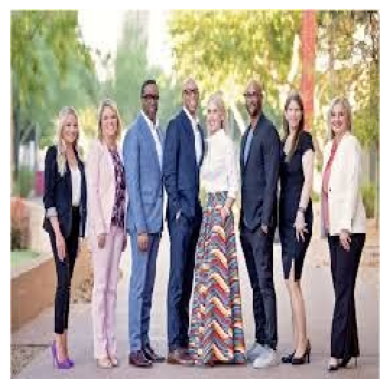

In [60]:
import os
import random
folder_number = random.randint(1, 2)  # Generate a random number between 1-3
if folder_number == 1:
    dataset_dir = "dataset/AI Art vs Real Art/AI Art/AiArtData"
else:
    dataset_dir = "dataset/AI Art vs Real Art/Real/RealArt"

print(dataset_dir)
file_list = os.listdir(dataset_dir)

random_file = random.choice(file_list)
print(random_file)
image_path = os.path.join(dataset_dir, random_file)

img = tf.keras.preprocessing.image.load_img(image_path, 
                                            target_size=(HEIGHT, WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]

total_percentage = sum(predictions)
scaled_predictions = [p * 100 / total_percentage for p in predictions]

# Define class names
class_names = ["AI Art", "Real"]

# Find the predicted class with the highest probability
predicted_class_index = tf.argmax(scaled_predictions).numpy()
predicted_class_name = class_names[predicted_class_index]

# Print the predicted label
print(f"This image is predicted to be: {predicted_class_name} ({scaled_predictions[predicted_class_index]:.2f}%)")

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()